In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm

C:\Users\cyun9\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Env():
    def __init__(self, n_action):
        self.n_action = n_action 
        self.init_states()

    def init_states(self):
        # 실제 Optimal q value 생성
        self.optimal_q_value_list = [np.random.normal(loc = 4, scale = 1) for i in range(self.n_action)]

    def get_reward(self, action:int):
        '''
        - Desc - 
        Action 값을 넣었을 때 해당 Action에 맞는 optimal_q 값으로부터 Reward 값을 반환 
        Reward 값은 평균이 실제 Optimal_q 값이고 variance가 1인 Normal Distribution 
        
        '''
        # reward distribution 생성
        return np.random.normal(loc = self.optimal_q_value_list[action], scale = 1)

## Gradient Bandit Algorithms

### Agent Class

In [3]:
class Agent():
    def __init__(self, n_action):
        self.n_action = n_action 
        self.actions = np.arange(self.n_action)
        self.init_values()

    def init_values(self):
        # 실제 optimal q value 생성 
        self.baseline = 0
        self.H = np.zeros(self.n_action)
        
    def step(self, env, alpha, baseline = True):
        '''
        한번의 time step 진행.
        
        '''
        prob = self.softmax() 
        action = self.get_action(prob)
        reward = env.get_reward(action)

        # baseline 업데이트 
        if baseline == True : 
            self.baseline = self.baseline + alpha * (reward - self.baseline)
        else : 
            self.baseline = 0

        # Action들의 Preference(self.H) 업데이트. 
        ## selected action update
        self.H[action] = self.H[action] + alpha * (reward - self.baseline) * (1 - prob[action])
        
        ## non-selected action update
        non_selected_action = self.actions != np.array(action)
        self.H[non_selected_action] = self.H[non_selected_action] - alpha * (reward - self.baseline) * prob[non_selected_action]
        return action, reward

    def get_action(self, prob):
        return np.random.choice(self.actions, p = prob)

    def softmax(self):
        denom = np.sum([np.exp(H) for H in self.H])
        prob_list = [np.exp(H) / denom for H in self.H]
        return np.array(prob_list)

In [4]:
[1, 2, 3] == np.array(3)

array([False, False,  True])

### Gradient Bandit Algorithms

In [5]:
# Run 
n_run = 2 # 2000
n_step = 1000
n_action = 10
env = Env(n_action)
agent = Agent(n_action)
epsilon = 0.0

In [6]:
def experiment(n_action, n_episode, n_step, alpha, baseline):
    env = Env(n_action)
    agent = Agent(n_action)

    episode_reward_list = []
    episode_action_tf_list = []
    
    for run in tqdm(range(n_episode)):
        env.init_states()
        agent.init_values()
        best_action = np.argmax(env.optimal_q_value_list)
        
        reward_list = []
        action_tf_list = []
        for step in range(n_step):
            action, reward = agent.step(env, alpha, baseline)
            
            reward_list.append(reward)        
            action_tf_list.append(action == best_action)
        
        episode_reward_list.append(reward_list)
        episode_action_tf_list.append(action_tf_list)
        
    return episode_reward_list, episode_action_tf_list

In [7]:
alpha_01_baseline_reward_list, alpha_01_baseline_action_list = experiment(n_action, n_episode=500, n_step = 1000, alpha=0.1, baseline = True)
alpha_04_baseline_reward_list, alpha_04_baseline_action_list = experiment(n_action, n_episode=500, n_step = 1000, alpha=0.4, baseline = True)
alpha_01_reward_list, alpha_01_action_list = experiment(n_action, n_episode=500, n_step = 1000, alpha=0.1, baseline = False)
alpha_04_reward_list, alpha_04_action_list = experiment(n_action, n_episode=500, n_step = 1000, alpha=0.4, baseline = False)

100%|██████████| 500/500 [00:39<00:00, 12.73it/s]


In [8]:
alpha_01_baseline_action_pd = [pd.DataFrame(x) for x in alpha_01_baseline_action_list]
alpha_04_baseline_action_pd = [pd.DataFrame(x) for x in alpha_04_baseline_action_list]
alpha_01_action_pd = [pd.DataFrame(x) for x in alpha_01_action_list]
alpha_04_action_pd = [pd.DataFrame(x) for x in alpha_04_action_list]

alpha_01_baseline_action_avg = pd.concat(alpha_01_baseline_action_pd, axis = 1).mean(axis=1)
alpha_04_baseline_action_avg = pd.concat(alpha_04_baseline_action_pd, axis = 1).mean(axis=1)
alpha_01_action_avg = pd.concat(alpha_01_action_pd, axis = 1).mean(axis=1)
alpha_04_action_avg = pd.concat(alpha_04_action_pd, axis = 1).mean(axis=1)

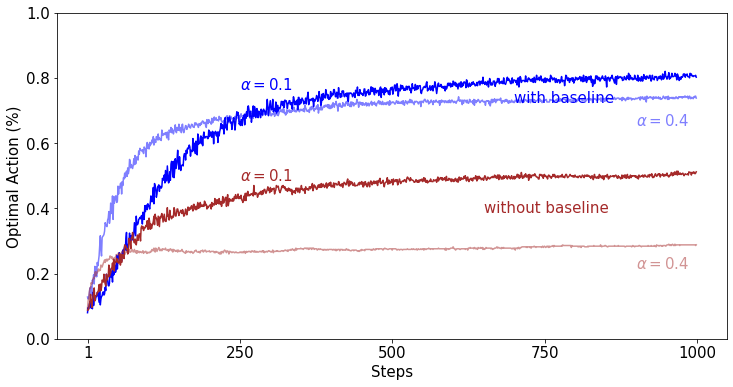

In [9]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.figure(figsize = (12, 6))
plt.plot(alpha_01_baseline_action_avg, 'b')
plt.text(250, 0.78, r'$ \alpha = 0.1$', fontsize=15, ha = 'left', va='center', color='b')
plt.text(700, 0.74, 'with baseline', fontsize=15, ha = 'left', va='center', color='b')
plt.plot(alpha_04_baseline_action_avg, 'b', alpha = 0.5)
plt.text(900, 0.67, r'$ \alpha = 0.4$', fontsize=15, ha = 'left', va='center', color='b', alpha = 0.5)
plt.plot(alpha_01_action_avg, 'brown')
plt.text(250, 0.5, r'$ \alpha = 0.1$', fontsize=15, ha = 'left', va='center', color='brown')
plt.text(650, 0.4, 'without baseline', fontsize=15, ha = 'left', va='center', color='brown')
plt.plot(alpha_04_action_avg, 'brown', alpha = 0.5)
plt.text(900, 0.23, r'$ \alpha = 0.4$', fontsize=15, ha = 'left', va='center', color='brown', alpha = 0.5)

plt.xlabel('Steps', fontsize=15)
plt.ylabel('Optimal Action (%)', fontsize=15)
plt.xticks([1, 250, 500, 750, 1000])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()